# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler as ss
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score


from catboost import CatBoostRegressor as cat
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install joypy


Note: you may need to restart the kernel to use updated packages.


In [3]:
import joypy


In [4]:
# Loading dataset
data = pd.read_csv('/datasets/taxi.csv')
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
# Changing datatype of columnd('datetime') to datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
# Observing dataset
print(data.info())
print(data.describe())
print(data['datetime'].min(), data['datetime'].max())
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000
2018-03-01 00:00:00 2018-08-31 23:50:00
                 datetime  num_orders
0     2018-03-01 00:00:00           9
1     2018-03-01 00:10:00          14
2     2018-03-01 00:20:00          28
3     2018-03-01 00:30:00          20
4     2018-03-01 00:40:00          32
...                   ...         ...
26491 2018-08-31 23:10:00          32
26492 2018-08-31 23:20:00          24
26493 2018-08-31 23:30:00          27
26494 2018-08-31 23:40:00          3

In [7]:
data.sort_index(inplace=True)
data.index.is_monotonic


True


We analyzed the data and saw that there were no missing values. It has two columns, one representing time and the other the amount of orders that occured during that time period. Then we put the data in order ascending order by time.

## Analysis

In [8]:
datahour = data.copy()
datahour.set_index('datetime', inplace=True)
datahour = datahour.resample('1H').sum()

def data2(data, dt_field, target, max_lag=1, rolling_window=1):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayoftheweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(str(lag))] = data[target].shift(lag)
    
    data['rolling_mean'] = data[target].shift().rolling(rolling_window).mean()
    data['rolling_median'] = data[target].shift().rolling(rolling_window).median()
    data['rolling_std'] = data[target].shift().rolling(rolling_window).std()
    
data2(datahour, 'datetime', 'num_orders', max_lag=7, rolling_window=7)

datahour2 = datahour.copy()

datahour = datahour.fillna('0')


datahour.reset_index(inplace=True)

datahour

,datetime,num_orders,month,day,dayoftheweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
0,2018-03-01 00:00:00,124,3,1,3,0,0,0,0,0,0,0,0,0,0,0
1,2018-03-01 01:00:00,85,3,1,3,1,124.0,0,0,0,0,0,0,0,0,0
2,2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,0,0,0,0,0,0,0,0
3,2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,0,0,0,0,0,0,0
4,2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571,166.0,40.244491
4412,2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.428571,166.0,40.244491
4413,2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,165.714286,154.0,40.569752
4414,2018-08-31 22:00:00,223,8,31,4,22,159.0,154.0,136.0,207.0,217.0,197.0,116.0,169.428571,159.0,38.196235


In [9]:
change = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7','rolling_median']
datahour[change] = datahour[change].astype('float')

changes = ['rolling_mean','rolling_std']
datahour[changes] = datahour[changes].astype('float')


In [10]:
change = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7','rolling_median']
datahour[change] = datahour[change].astype('Int16')


In [11]:
datahour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        4416 non-null   datetime64[ns]
 1   num_orders      4416 non-null   int64         
 2   month           4416 non-null   int64         
 3   day             4416 non-null   int64         
 4   dayoftheweek    4416 non-null   int64         
 5   hour            4416 non-null   int64         
 6   lag_1           4416 non-null   Int16         
 7   lag_2           4416 non-null   Int16         
 8   lag_3           4416 non-null   Int16         
 9   lag_4           4416 non-null   Int16         
 10  lag_5           4416 non-null   Int16         
 11  lag_6           4416 non-null   Int16         
 12  lag_7           4416 non-null   Int16         
 13  rolling_mean    4416 non-null   float64       
 14  rolling_median  4416 non-null   Int16         
 15  roll

<Figure size 480x480 with 0 Axes>

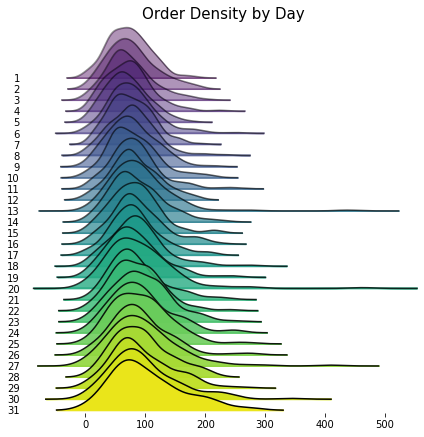

In [12]:
plt.figure(figsize=(6,6), dpi= 80)

fig, axes = joypy.joyplot(datahour, column=['num_orders'], by="day", ylim='own', figsize=(6,6),range_style='own', colormap=plt.cm.viridis,fade='True')

plt.title('Order Density by Day', fontsize=15)
plt.show()



<Figure size 480x480 with 0 Axes>

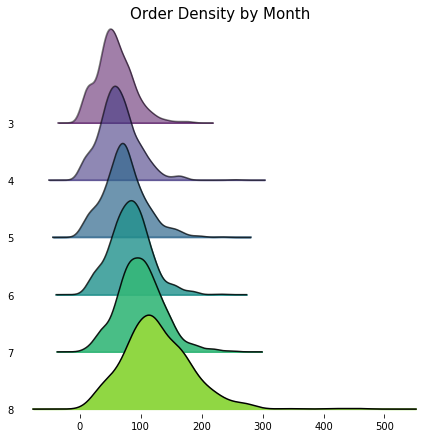

In [13]:
plt.figure(figsize=(6,6), dpi= 80)

fig, axes = joypy.joyplot(datahour, column=['num_orders'], by="month", ylim='own', figsize=(6,6),colormap=plt.cm.viridis,fade='True', range_style='own')

plt.title('Order Density by Month', fontsize=15)
plt.show()


Here we observe order density by day and by month. We see that there are bumps in orders every 13th, 20th and 27th day. We also observe that from march to september there is a slight but noticiable increase in orders.

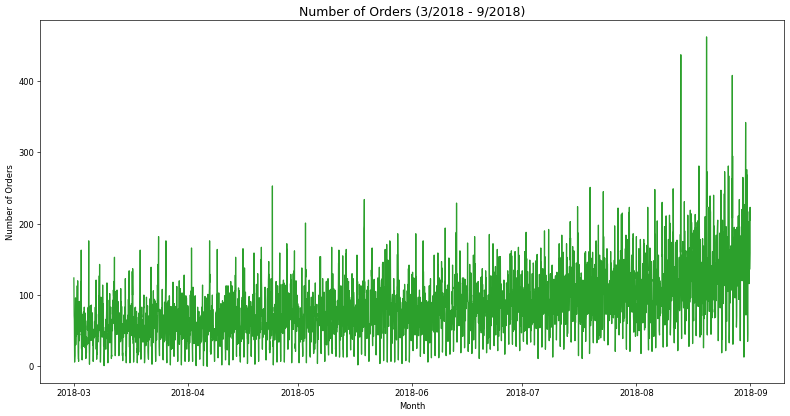

In [14]:
plt.figure(figsize=(16,8), dpi= 60)
plt.plot('datetime', 'num_orders', data=datahour, color='tab:green')

plt.title("Number of Orders (3/2018 - 9/2018)", fontsize=15)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

This graph shows that the number of orders increased in volume relative with time. Highs all occuring in august and september.

## Training

In [15]:
display(datahour2)

,num_orders,month,day,dayoftheweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571,166.0,40.244491
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.428571,166.0,40.244491
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,165.714286,154.0,40.569752


In [16]:
# splitting the data


X = datahour2.drop('num_orders', axis=1)
y = datahour2['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [17]:
tscv = TimeSeriesSplit()


In [18]:
# standard scaling
sc = ss()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
# rmse
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_scorer = make_scorer(rmse, greater_is_better = False)

In [21]:
XGB = XGBRegressor(n_jobs=-1, random_state=12345)
XGB_base = np.mean(abs(cross_val_score(XGB,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
XGB_base

26.443438089719997

In [22]:
CB = cat(verbose=0, loss_function="RMSE", random_state=12345)
CB_base = np.mean(abs(cross_val_score(CB,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
CB_base

25.159293380456806

In [23]:
LGB = LGBMRegressor(random_state=12345)
LGB_base = np.mean(abs(cross_val_score(LGB,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
LGB_base

25.34173814194568

Catboost performs slightly better than the LGBM Regressor model so we will run it on the test set to see if it performs well.

## Testing

In [24]:
CB = cat(verbose=0, loss_function="RMSE", random_state=12345)
CB.fit(X_train, y_train)

y_pred_test = CB.predict(X_test)
CB_test_score = rmse(y_test, y_pred_test)
CB_test_score

43.646199107761646

We run the catboost model on the test set and the rmse is less than 48.